<a href="https://colab.research.google.com/github/takman99/Stock-Market-Prediction-Using-LSTM-and-GRU-Neural-Networks/blob/main/GRU_Multi_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU Model



In [ ]:
# Importing libraries
!pip install yfinance --upgrade --no-cache-dir
!pip install --upgrade pandas
!pip install pycryptodome pycryptodomex
!pip uninstall --yes pandas-datareader
!pip install git+https://github.com/raphi6/pandas-datareader.git@ea66d6b981554f9d0262038aef2106dda7138316
!pip install scikit-optimize
import math
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_datareader as web
import tensorflow as tf
from tensorflow.keras.regularizers import L1, L2, L1L2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
from keras.activations import relu, tanh, linear
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 150.9 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.22
    Uninstalling yfinance-0.2.22:
      Successfully uninstalled yfinance-0.2.22
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 36.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.3 MB/s eta 0:00:00
Found existing in

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = yf.download("^GSPC", start="2000-01-03", end="2016-11-10")

# Selecting the 6 input features
data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
dataset = data.values

training_data_len = len(dataset) - 400

# Fitting the MinMaxScaler only on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset[:training_data_len])

# Transforming both the training and test data using the fitted scaler
scaled_data = scaler.transform(dataset)

train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, :])
    y_train.append(train_data[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 6))

#Test data
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, 3]

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 6))

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Determining the index where the validation set should start
validation_start_index = int(x_train.shape[0] * 0.8)

# Splitting the training data into training and validation sets
x_train, x_val = x_train[:validation_start_index], x_train[validation_start_index:]
y_train, y_val = y_train[:validation_start_index], y_train[validation_start_index:]


def gru_model_optimize(params):
    learning_rate, epochs, batch_size, dropout, activation_function, optimizer, neurons_1, neurons_2, neurons_3, neurons_4, l2_lambda = params

    model = Sequential()
    model.add(GRU(neurons_1, return_sequences=True, input_shape=(x_train.shape[1], 6), activation=activation_function, kernel_regularizer=L2(l2_lambda)))
    model.add(Dropout(dropout))
    model.add(GRU(neurons_2, return_sequences=False, activation=activation_function, kernel_regularizer=L2(l2_lambda)))
    model.add(Dropout(dropout))
    model.add(Dense(neurons_3, activation=activation_function))
    model.add(Dense(neurons_4))

    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping])


    predictions = model.predict(x_val)
    predicted_data = np.zeros((predictions.shape[0], dataset.shape[1]))
    predicted_data[:, 3] = predictions[:, 0]
    predictions = scaler.inverse_transform(predicted_data)[:, 3]


    # Inverse transform y_val
    y_val_unscaled_data = np.zeros((y_val.shape[0], dataset.shape[1]))
    y_val_unscaled_data[:, 3] = y_val
    y_val_unscaled = scaler.inverse_transform(y_val_unscaled_data)[:, 3]

    mse = np.mean(((predictions - y_val_unscaled) ** 2))

    rmse = np.sqrt(np.mean(((predictions - y_val_unscaled) ** 2)))
    print('rmse=', rmse)
    #Checking if MSE is "nan" and return a large value if it is
    if np.isnan(mse):
        return 1e6
    else:
      return mse


# Defining the search space for hyperparameters
space = [
    Categorical([0.0001, 0.001], name="learning_rate"),
    Categorical([100, 200, 300, 400, 500, 1000], name="epochs"),
    Categorical([8, 16, 32], name="batch_size"),
    Categorical([0.1, 0.2], name="dropout"),
    Categorical(['tanh'], name="activation_function"),
    Categorical([Adam], name="optimizer"),
    Categorical([80, 100, 120, 140, 160, 180, 200], name="neurons_1"),
    Categorical([80, 100, 120, 140, 160, 180, 200], name="neurons_2"),
    Categorical([25], name="neurons_3"),
    Categorical([1], name="neurons_4"),
    Categorical([0.0001, 0.00005,0.001, 0.005], name="l2_lambda"),

]


early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# Performing Bayesian optimization using gp_minimize
result = gp_minimize(gru_model_optimize, space, n_calls=12, n_random_starts=10, verbose=1, n_jobs=-1)

# Extracting the optimal hyperparameters
opt_learning_rate, opt_epochs, opt_batch_size, opt_dropout, opt_activation_function, opt_optimizer, opt_neurons_1, opt_neurons_2,opt_neurons_3,opt_neurons_4, opt_l2_lambda = result.x

# Training the GRU model with the optimal hyperparameters
model = Sequential()
model.add(GRU(opt_neurons_1, return_sequences=True, input_shape=(x_train.shape[1], 6), activation=opt_activation_function, kernel_regularizer=L2(opt_l2_lambda)))
model.add(Dropout(opt_dropout))
model.add(GRU(opt_neurons_2, return_sequences=False, activation=opt_activation_function, kernel_regularizer=L2(opt_l2_lambda)))
model.add(Dropout(opt_dropout))
model.add(Dense(opt_neurons_3, activation=opt_activation_function))
model.add(Dense(opt_neurons_4))

opt = opt_optimizer(learning_rate=opt_learning_rate)
model.compile(optimizer=opt, loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=opt_batch_size, epochs=opt_epochs, verbose=1, callbacks=[early_stopping])

predictions = model.predict(x_test)
predicted_data = np.zeros((predictions.shape[0], dataset.shape[1]))
predicted_data[:, 3] = predictions[:, 0]
predictions = scaler.inverse_transform(predicted_data)[:, 3]


# Calculating Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('rmse= ' + str(rmse))

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(predictions, y_test)
print('mae= ' + str(mae))


# Calculating Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predictions - y_test) / y_test)) * 100
print('mape= ' + str(mape))

# Calculating Adjusted Mean Absolute Percentage Error (AMAPE)
amape = np.mean(np.abs((predictions - y_test) / np.mean(y_test))) * 100
print('amape= ' + str(amape))


print("Optimal learning rate:", opt_learning_rate)
print("Optimal epochs:", opt_epochs)
print("Optimal batch size:", opt_batch_size)
print("Optimal dropout rate:", opt_dropout)
print("Optimal activation function:", opt_activation_function)
print("Optimal optimizer:", opt_optimizer.__name__)
print("Optimal neurons for the first GRU layer:", opt_neurons_1)
print("Optimal neurons for the second GRU layer:", opt_neurons_2)
print("Optimal Dense neuron 1:", opt_neurons_3)
print("Optimal Dense neuron 2:", opt_neurons_4)
print("L2 regularization lambda:", opt_l2_lambda)


Iteration No: 1 started. Evaluating function at random point.
Epoch 1/1000
95/95 [==============================] - 5s 15ms/step - loss: 0.0922 - val_loss: 0.0385
Epoch 2/1000
95/95 [==============================] - 1s 8ms/step - loss: 0.0235 - val_loss: 0.0180
Epoch 3/1000
95/95 [==============================] - 1s 8ms/step - loss: 0.0116 - val_loss: 0.0100
Epoch 4/1000
95/95 [==============================] - 1s 8ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 5/1000
95/95 [==============================] - 1s 8ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 6/1000
95/95 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0057
Epoch 7/1000
95/95 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/1000
95/95 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/1000
95/95 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.9113e-04
Epoch 10/1000
95/95 [============

379/379 [==============================] - 5s 7ms/step - loss: 0.0065
Epoch 2/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0029

379/379 [==============================] - 2s 7ms/step - loss: 0.0029
Epoch 3/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0020

379/379 [==============================] - 2s 7ms/step - loss: 0.0020
Epoch 4/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0014

379/379 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 5/1000
379/379 [==============================] - ETA: 0s - loss: 0.0010

379/379 [==============================] - 3s 7ms/step - loss: 0.0010
Epoch 6/1000
374/379 [============================>.] - ETA: 0s - loss: 7.8867e-04

379/379 [==============================] - 3s 7ms/step - loss: 7.8732e-04
Epoch 7/1000
377/379 [============================>.] - ETA: 0s - loss: 6.0507e-04

379/379 [==============================] - 2s 7ms/step - loss: 6.0480e-04
Epoch 8/1000
377/379 [============================>.] - ETA: 0s - loss: 5.1219e-04

379/379 [==============================] - 2s 7ms/step - loss: 5.1236e-04
Epoch 9/1000
377/379 [============================>.] - ETA: 0s - loss: 4.8679e-04

379/379 [==============================] - 2s 7ms/step - loss: 4.8642e-04
Epoch 10/1000
374/379 [============================>.] - ETA: 0s - loss: 4.2811e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.2598e-04
Epoch 11/1000
373/379 [============================>.] - ETA: 0s - loss: 4.6634e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.6709e-04
Epoch 12/1000
377/379 [============================>.] - ETA: 0s - loss: 4.0285e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.0230e-04
Epoch 13/1000
377/379 [============================>.] - ETA: 0s - loss: 4.2011e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.1975e-04
Epoch 14/1000
377/379 [============================>.] - ETA: 0s - loss: 3.9177e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.9144e-04
Epoch 15/1000
379/379 [==============================] - ETA: 0s - loss: 3.8980e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.8980e-04
Epoch 16/1000
375/379 [============================>.] - ETA: 0s - loss: 4.0780e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.0766e-04
Epoch 17/1000
377/379 [============================>.] - ETA: 0s - loss: 3.8800e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.8762e-04
Epoch 18/1000
376/379 [============================>.] - ETA: 0s - loss: 4.1592e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.1564e-04
Epoch 19/1000
377/379 [============================>.] - ETA: 0s - loss: 3.6850e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.6940e-04
Epoch 20/1000
375/379 [============================>.] - ETA: 0s - loss: 3.8628e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.8608e-04
Epoch 21/1000
376/379 [============================>.] - ETA: 0s - loss: 3.9188e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.9223e-04
Epoch 22/1000
376/379 [============================>.] - ETA: 0s - loss: 4.1662e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.1690e-04
Epoch 23/1000
377/379 [============================>.] - ETA: 0s - loss: 3.8231e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.8209e-04
Epoch 24/1000
373/379 [============================>.] - ETA: 0s - loss: 3.5398e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.5362e-04
Epoch 25/1000
379/379 [==============================] - ETA: 0s - loss: 4.1357e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.1357e-04
Epoch 26/1000
376/379 [============================>.] - ETA: 0s - loss: 3.7132e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.7140e-04
Epoch 27/1000
377/379 [============================>.] - ETA: 0s - loss: 3.5987e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.6136e-04
Epoch 28/1000
375/379 [============================>.] - ETA: 0s - loss: 4.2001e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.2008e-04
Epoch 29/1000
376/379 [============================>.] - ETA: 0s - loss: 3.8039e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.8060e-04
Epoch 30/1000
377/379 [============================>.] - ETA: 0s - loss: 3.8576e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.8580e-04
Epoch 31/1000
375/379 [============================>.] - ETA: 0s - loss: 3.9208e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.9084e-04
Epoch 32/1000
376/379 [============================>.] - ETA: 0s - loss: 3.7815e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.7897e-04
Epoch 33/1000
377/379 [============================>.] - ETA: 0s - loss: 3.5224e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.5186e-04
Epoch 34/1000
376/379 [============================>.] - ETA: 0s - loss: 3.5063e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.5153e-04
Epoch 35/1000
377/379 [============================>.] - ETA: 0s - loss: 3.6694e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.6679e-04
Epoch 36/1000
375/379 [============================>.] - ETA: 0s - loss: 3.5177e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.5236e-04
Epoch 37/1000
377/379 [============================>.] - ETA: 0s - loss: 3.8078e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.8077e-04
Epoch 38/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3289e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.3296e-04
Epoch 39/1000
377/379 [============================>.] - ETA: 0s - loss: 3.6418e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.6363e-04
Epoch 40/1000
376/379 [============================>.] - ETA: 0s - loss: 3.1285e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.1274e-04
Epoch 41/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3327e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.3292e-04
Epoch 42/1000
376/379 [============================>.] - ETA: 0s - loss: 3.2579e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2545e-04
Epoch 43/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1748e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1818e-04
Epoch 44/1000
377/379 [============================>.] - ETA: 0s - loss: 3.4038e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.4008e-04
Epoch 45/1000
377/379 [============================>.] - ETA: 0s - loss: 3.2244e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.2227e-04
Epoch 46/1000
372/379 [============================>.] - ETA: 0s - loss: 3.5240e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.5389e-04
Epoch 47/1000
377/379 [============================>.] - ETA: 0s - loss: 3.6443e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.6462e-04
Epoch 48/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3422e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.3369e-04
Epoch 49/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3549e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.3533e-04
Epoch 50/1000
377/379 [============================>.] - ETA: 0s - loss: 3.2676e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2669e-04
Epoch 51/1000
375/379 [============================>.] - ETA: 0s - loss: 3.3584e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.3666e-04
Epoch 52/1000
373/379 [============================>.] - ETA: 0s - loss: 3.2133e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2046e-04
Epoch 53/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3191e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.3128e-04
Epoch 54/1000
377/379 [============================>.] - ETA: 0s - loss: 3.2414e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.2533e-04
Epoch 55/1000
377/379 [============================>.] - ETA: 0s - loss: 3.5885e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.5840e-04
Epoch 56/1000
376/379 [============================>.] - ETA: 0s - loss: 3.2435e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2427e-04
Epoch 57/1000
376/379 [============================>.] - ETA: 0s - loss: 3.1633e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1573e-04
Epoch 58/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3626e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.3696e-04
Epoch 59/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0690e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0679e-04
Epoch 60/1000
377/379 [============================>.] - ETA: 0s - loss: 3.2636e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.2624e-04
Epoch 61/1000
374/379 [============================>.] - ETA: 0s - loss: 3.2062e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2010e-04
Epoch 62/1000
374/379 [============================>.] - ETA: 0s - loss: 3.2390e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2268e-04
Epoch 63/1000
375/379 [============================>.] - ETA: 0s - loss: 3.3154e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.3251e-04
Epoch 64/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3609e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.3564e-04
Epoch 65/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1639e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.1675e-04
Epoch 66/1000
377/379 [============================>.] - ETA: 0s - loss: 3.2094e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.2154e-04
Epoch 67/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1790e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1753e-04
Epoch 68/1000
375/379 [============================>.] - ETA: 0s - loss: 3.5867e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.5730e-04
Epoch 69/1000
375/379 [============================>.] - ETA: 0s - loss: 3.1442e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1672e-04
Epoch 70/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0482e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0525e-04
Epoch 71/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0370e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.0329e-04
Epoch 72/1000
377/379 [============================>.] - ETA: 0s - loss: 3.2411e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2473e-04
Epoch 73/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1853e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1839e-04
Epoch 74/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0311e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0296e-04
Epoch 75/1000
374/379 [============================>.] - ETA: 0s - loss: 3.1118e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1050e-04
Epoch 76/1000
375/379 [============================>.] - ETA: 0s - loss: 3.0132e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0040e-04
Epoch 77/1000
378/379 [============================>.] - ETA: 0s - loss: 3.0981e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0973e-04
Epoch 78/1000
378/379 [============================>.] - ETA: 0s - loss: 3.1492e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1486e-04
Epoch 79/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1468e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1589e-04
Epoch 80/1000
376/379 [============================>.] - ETA: 0s - loss: 3.2116e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.2155e-04
Epoch 81/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3199e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.3195e-04
Epoch 82/1000
379/379 [==============================] - ETA: 0s - loss: 3.0585e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0585e-04
Epoch 83/1000
374/379 [============================>.] - ETA: 0s - loss: 3.1247e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1273e-04
Epoch 84/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3176e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.3192e-04
Epoch 85/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9010e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9022e-04
Epoch 86/1000
375/379 [============================>.] - ETA: 0s - loss: 3.5200e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.5187e-04
Epoch 87/1000
379/379 [==============================] - ETA: 0s - loss: 2.9412e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9412e-04
Epoch 88/1000
378/379 [============================>.] - ETA: 0s - loss: 2.9699e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9705e-04
Epoch 89/1000
377/379 [============================>.] - ETA: 0s - loss: 3.3931e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.3897e-04
Epoch 90/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1863e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.1929e-04
Epoch 91/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1167e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.1328e-04
Epoch 92/1000
378/379 [============================>.] - ETA: 0s - loss: 3.1008e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1000e-04
Epoch 93/1000
374/379 [============================>.] - ETA: 0s - loss: 2.9501e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9440e-04
Epoch 94/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7405e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7437e-04
Epoch 95/1000
377/379 [============================>.] - ETA: 0s - loss: 3.2503e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2508e-04
Epoch 96/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0970e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1033e-04
Epoch 97/1000
373/379 [============================>.] - ETA: 0s - loss: 3.0033e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9947e-04
Epoch 98/1000
379/379 [==============================] - ETA: 0s - loss: 3.2042e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2042e-04
Epoch 99/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9317e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9278e-04
Epoch 100/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0486e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0492e-04
Epoch 101/1000
376/379 [============================>.] - ETA: 0s - loss: 2.9791e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9721e-04
Epoch 102/1000
375/379 [============================>.] - ETA: 0s - loss: 2.8951e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8897e-04
Epoch 103/1000
374/379 [============================>.] - ETA: 0s - loss: 3.1399e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1394e-04
Epoch 104/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0464e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0414e-04
Epoch 105/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9933e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0006e-04
Epoch 106/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1257e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1262e-04
Epoch 107/1000
374/379 [============================>.] - ETA: 0s - loss: 2.9932e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9891e-04
Epoch 108/1000
372/379 [============================>.] - ETA: 0s - loss: 2.8372e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8233e-04
Epoch 109/1000
376/379 [============================>.] - ETA: 0s - loss: 2.9057e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9036e-04
Epoch 110/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0534e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.0547e-04
Epoch 111/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9696e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9700e-04
Epoch 112/1000
376/379 [============================>.] - ETA: 0s - loss: 2.9902e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9841e-04
Epoch 113/1000
374/379 [============================>.] - ETA: 0s - loss: 2.8299e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8348e-04
Epoch 114/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0962e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0916e-04
Epoch 115/1000
376/379 [============================>.] - ETA: 0s - loss: 3.1263e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1272e-04
Epoch 116/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0599e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.0546e-04
Epoch 117/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9789e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.9770e-04
Epoch 118/1000
374/379 [============================>.] - ETA: 0s - loss: 3.0142e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0203e-04
Epoch 119/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1713e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1703e-04
Epoch 120/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8531e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8490e-04
Epoch 121/1000
375/379 [============================>.] - ETA: 0s - loss: 2.9983e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9973e-04
Epoch 122/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1607e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1877e-04
Epoch 123/1000
373/379 [============================>.] - ETA: 0s - loss: 3.2429e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2405e-04
Epoch 124/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7393e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7388e-04
Epoch 125/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1930e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.1905e-04
Epoch 126/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9398e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.9397e-04
Epoch 127/1000
376/379 [============================>.] - ETA: 0s - loss: 2.7125e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7146e-04
Epoch 128/1000
379/379 [==============================] - ETA: 0s - loss: 3.1645e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1645e-04
Epoch 129/1000
374/379 [============================>.] - ETA: 0s - loss: 2.9194e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9165e-04
Epoch 130/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9288e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.9267e-04
Epoch 131/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8756e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.8768e-04
Epoch 132/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9375e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.9330e-04
Epoch 133/1000
378/379 [============================>.] - ETA: 0s - loss: 2.9146e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9139e-04
Epoch 134/1000
375/379 [============================>.] - ETA: 0s - loss: 2.8354e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8404e-04
Epoch 135/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0227e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.0170e-04
Epoch 136/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0390e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.0377e-04
Epoch 137/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0195e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.0317e-04
Epoch 138/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6989e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6973e-04
Epoch 139/1000
372/379 [============================>.] - ETA: 0s - loss: 3.0344e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0319e-04
Epoch 140/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0656e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0677e-04
Epoch 141/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9145e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.9253e-04
Epoch 142/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8740e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.8696e-04
Epoch 143/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9105e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.9070e-04
Epoch 144/1000
374/379 [============================>.] - ETA: 0s - loss: 2.7339e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7462e-04
Epoch 145/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8458e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8439e-04
Epoch 146/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8572e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8540e-04
Epoch 147/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9477e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9450e-04
Epoch 148/1000
375/379 [============================>.] - ETA: 0s - loss: 2.7843e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7895e-04
Epoch 149/1000
373/379 [============================>.] - ETA: 0s - loss: 3.0620e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0708e-04
Epoch 150/1000
375/379 [============================>.] - ETA: 0s - loss: 2.7999e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7952e-04
Epoch 151/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7982e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7944e-04
Epoch 152/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7107e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7148e-04
Epoch 153/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7527e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7585e-04
Epoch 154/1000
374/379 [============================>.] - ETA: 0s - loss: 3.0793e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0770e-04
Epoch 155/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8446e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8441e-04
Epoch 156/1000
376/379 [============================>.] - ETA: 0s - loss: 2.8192e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8332e-04
Epoch 157/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7810e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7798e-04
Epoch 158/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8987e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.8949e-04
Epoch 159/1000
378/379 [============================>.] - ETA: 0s - loss: 3.0769e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0763e-04
Epoch 160/1000
376/379 [============================>.] - ETA: 0s - loss: 2.7563e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7561e-04
Epoch 161/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7569e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7599e-04
Epoch 162/1000
376/379 [============================>.] - ETA: 0s - loss: 2.7974e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8011e-04
Epoch 163/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7992e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7980e-04
Epoch 164/1000
373/379 [============================>.] - ETA: 0s - loss: 2.9076e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9063e-04
Epoch 165/1000
375/379 [============================>.] - ETA: 0s - loss: 2.6783e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6770e-04
Epoch 166/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8691e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8717e-04
Epoch 167/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7302e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7290e-04
Epoch 168/1000
376/379 [============================>.] - ETA: 0s - loss: 2.7837e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7776e-04
Epoch 169/1000
372/379 [============================>.] - ETA: 0s - loss: 2.7742e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7645e-04
Epoch 170/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8059e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8059e-04
Epoch 171/1000
376/379 [============================>.] - ETA: 0s - loss: 2.8461e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.8419e-04
Epoch 172/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8411e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8452e-04
Epoch 173/1000
375/379 [============================>.] - ETA: 0s - loss: 2.8162e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8136e-04
Epoch 174/1000
372/379 [============================>.] - ETA: 0s - loss: 2.7097e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7231e-04
Epoch 175/1000
376/379 [============================>.] - ETA: 0s - loss: 2.9407e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9388e-04
Epoch 176/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8720e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.8702e-04
Epoch 177/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7679e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7673e-04
Epoch 178/1000
378/379 [============================>.] - ETA: 0s - loss: 2.6998e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6993e-04
Epoch 179/1000
374/379 [============================>.] - ETA: 0s - loss: 2.8000e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7896e-04
Epoch 180/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8200e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8184e-04
Epoch 181/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7724e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7714e-04
Epoch 182/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8124e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8111e-04
Epoch 183/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9667e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9617e-04
Epoch 184/1000
378/379 [============================>.] - ETA: 0s - loss: 2.6813e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6807e-04
Epoch 185/1000
373/379 [============================>.] - ETA: 0s - loss: 2.7608e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7600e-04
Epoch 186/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8352e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.8336e-04
Epoch 187/1000
377/379 [============================>.] - ETA: 0s - loss: 3.0604e-04

379/379 [==============================] - 2s 7ms/step - loss: 3.0605e-04
Epoch 188/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8869e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.8824e-04
Epoch 189/1000
374/379 [============================>.] - ETA: 0s - loss: 2.7144e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7078e-04
Epoch 190/1000
378/379 [============================>.] - ETA: 0s - loss: 2.8086e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8080e-04
Epoch 191/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6890e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6860e-04
Epoch 192/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9033e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8980e-04
Epoch 193/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6660e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6659e-04
Epoch 194/1000
376/379 [============================>.] - ETA: 0s - loss: 2.7374e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7425e-04
Epoch 195/1000
372/379 [============================>.] - ETA: 0s - loss: 2.6591e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6447e-04
Epoch 196/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9446e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9400e-04
Epoch 197/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5994e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6027e-04
Epoch 198/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7690e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7682e-04
Epoch 199/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6951e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6988e-04
Epoch 200/1000
373/379 [============================>.] - ETA: 0s - loss: 2.6803e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6876e-04
Epoch 201/1000
375/379 [============================>.] - ETA: 0s - loss: 2.6761e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6732e-04
Epoch 202/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6366e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6333e-04
Epoch 203/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6363e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6463e-04
Epoch 204/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5205e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5178e-04
Epoch 205/1000
373/379 [============================>.] - ETA: 0s - loss: 2.5917e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6009e-04
Epoch 206/1000
376/379 [============================>.] - ETA: 0s - loss: 2.8018e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7974e-04
Epoch 207/1000
376/379 [============================>.] - ETA: 0s - loss: 2.7151e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7099e-04
Epoch 208/1000
375/379 [============================>.] - ETA: 0s - loss: 2.6740e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6757e-04
Epoch 209/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6429e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6439e-04
Epoch 210/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8358e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8366e-04
Epoch 211/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6733e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6695e-04
Epoch 212/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5027e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.5016e-04
Epoch 213/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8233e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.8224e-04
Epoch 214/1000
376/379 [============================>.] - ETA: 0s - loss: 2.7535e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7510e-04
Epoch 215/1000
378/379 [============================>.] - ETA: 0s - loss: 2.7737e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7733e-04
Epoch 216/1000
375/379 [============================>.] - ETA: 0s - loss: 3.0329e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0347e-04
Epoch 217/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8146e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8182e-04
Epoch 218/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6081e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6070e-04
Epoch 219/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7838e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7882e-04
Epoch 220/1000
374/379 [============================>.] - ETA: 0s - loss: 2.6310e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6357e-04
Epoch 221/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5899e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5941e-04
Epoch 222/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5527e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.5551e-04
Epoch 223/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8877e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8843e-04
Epoch 224/1000
377/379 [============================>.] - ETA: 0s - loss: 2.8672e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8655e-04
Epoch 225/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6161e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6115e-04
Epoch 226/1000
378/379 [============================>.] - ETA: 0s - loss: 2.6529e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6523e-04
Epoch 227/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7324e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7316e-04
Epoch 228/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6593e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6576e-04
Epoch 229/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6380e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6466e-04
Epoch 230/1000
374/379 [============================>.] - ETA: 0s - loss: 2.8531e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8456e-04
Epoch 231/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6423e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6380e-04
Epoch 232/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6955e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6972e-04
Epoch 233/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6466e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6440e-04
Epoch 234/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6292e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6263e-04
Epoch 235/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5628e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5601e-04
Epoch 236/1000
374/379 [============================>.] - ETA: 0s - loss: 2.7519e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7479e-04
Epoch 237/1000
374/379 [============================>.] - ETA: 0s - loss: 3.8333e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.8348e-04
Epoch 238/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9716e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.9682e-04
Epoch 239/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5998e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6014e-04
Epoch 240/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7272e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7264e-04
Epoch 241/1000
373/379 [============================>.] - ETA: 0s - loss: 2.4158e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4232e-04
Epoch 242/1000
379/379 [==============================] - ETA: 0s - loss: 2.5706e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5706e-04
Epoch 243/1000
375/379 [============================>.] - ETA: 0s - loss: 2.6264e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6183e-04
Epoch 244/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6771e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6755e-04
Epoch 245/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6723e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6711e-04
Epoch 246/1000
373/379 [============================>.] - ETA: 0s - loss: 2.7335e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7167e-04
Epoch 247/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4374e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4439e-04
Epoch 248/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7820e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7788e-04
Epoch 249/1000
375/379 [============================>.] - ETA: 0s - loss: 2.6784e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6758e-04
Epoch 250/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6527e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6502e-04
Epoch 251/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5981e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6024e-04
Epoch 252/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6510e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6492e-04
Epoch 253/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4381e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4444e-04
Epoch 254/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6132e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6158e-04
Epoch 255/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6407e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6384e-04
Epoch 256/1000
372/379 [============================>.] - ETA: 0s - loss: 2.6078e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6092e-04
Epoch 257/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6480e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6464e-04
Epoch 258/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6125e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6159e-04
Epoch 259/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6824e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6793e-04
Epoch 260/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5874e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5887e-04
Epoch 261/1000
379/379 [==============================] - ETA: 0s - loss: 2.6367e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6367e-04
Epoch 262/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5827e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5805e-04
Epoch 263/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7070e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7079e-04
Epoch 264/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7262e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.7317e-04
Epoch 265/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5695e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.5724e-04
Epoch 266/1000
378/379 [============================>.] - ETA: 0s - loss: 2.5725e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5725e-04
Epoch 267/1000
378/379 [============================>.] - ETA: 0s - loss: 2.5187e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5190e-04
Epoch 268/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6372e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6360e-04
Epoch 269/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5847e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5838e-04
Epoch 270/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6307e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6295e-04
Epoch 271/1000
372/379 [============================>.] - ETA: 0s - loss: 2.5667e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5505e-04
Epoch 272/1000
372/379 [============================>.] - ETA: 0s - loss: 2.6846e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6909e-04
Epoch 273/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6971e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6956e-04
Epoch 274/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6922e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6965e-04
Epoch 275/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5462e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5433e-04
Epoch 276/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5632e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5663e-04
Epoch 277/1000
373/379 [============================>.] - ETA: 0s - loss: 6.0557e-04

379/379 [==============================] - 3s 7ms/step - loss: 6.0447e-04
Epoch 278/1000
375/379 [============================>.] - ETA: 0s - loss: 3.7003e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.7091e-04
Epoch 279/1000
377/379 [============================>.] - ETA: 0s - loss: 3.1555e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.1561e-04
Epoch 280/1000
376/379 [============================>.] - ETA: 0s - loss: 2.9358e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9356e-04
Epoch 281/1000
376/379 [============================>.] - ETA: 0s - loss: 2.8788e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.8790e-04
Epoch 282/1000
374/379 [============================>.] - ETA: 0s - loss: 2.9987e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9948e-04
Epoch 283/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6327e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6352e-04
Epoch 284/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6606e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6543e-04
Epoch 285/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5892e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.5876e-04
Epoch 286/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5655e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5618e-04
Epoch 287/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5142e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5161e-04
Epoch 288/1000
372/379 [============================>.] - ETA: 0s - loss: 2.6479e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6641e-04
Epoch 289/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5802e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5768e-04
Epoch 290/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6049e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6079e-04
Epoch 291/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6626e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6681e-04
Epoch 292/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4867e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4742e-04
Epoch 293/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5499e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5510e-04
Epoch 294/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6982e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6934e-04
Epoch 295/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4847e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4819e-04
Epoch 296/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4042e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4250e-04
Epoch 297/1000
378/379 [============================>.] - ETA: 0s - loss: 2.5872e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5874e-04
Epoch 298/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5585e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5638e-04
Epoch 299/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5965e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6000e-04
Epoch 300/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6798e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6752e-04
Epoch 301/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5708e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5769e-04
Epoch 302/1000
372/379 [============================>.] - ETA: 0s - loss: 2.6895e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7078e-04
Epoch 303/1000
372/379 [============================>.] - ETA: 0s - loss: 2.6720e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6615e-04
Epoch 304/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4947e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4902e-04
Epoch 305/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5033e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5069e-04
Epoch 306/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5931e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6001e-04
Epoch 307/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6458e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6526e-04
Epoch 308/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5739e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5781e-04
Epoch 309/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4952e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4989e-04
Epoch 310/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6575e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.6531e-04
Epoch 311/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6418e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6429e-04
Epoch 312/1000
379/379 [==============================] - ETA: 0s - loss: 2.6111e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6111e-04
Epoch 313/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4291e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4307e-04
Epoch 314/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6512e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6501e-04
Epoch 315/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6759e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6733e-04
Epoch 316/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5789e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.5771e-04
Epoch 317/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6873e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6786e-04
Epoch 318/1000
373/379 [============================>.] - ETA: 0s - loss: 2.5548e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5473e-04
Epoch 319/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4764e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4806e-04
Epoch 320/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6789e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6774e-04
Epoch 321/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5017e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4982e-04
Epoch 322/1000
378/379 [============================>.] - ETA: 0s - loss: 2.4899e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4894e-04
Epoch 323/1000
378/379 [============================>.] - ETA: 0s - loss: 2.6450e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6446e-04
Epoch 324/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6021e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6025e-04
Epoch 325/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7120e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7066e-04
Epoch 326/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6354e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6382e-04
Epoch 327/1000
373/379 [============================>.] - ETA: 0s - loss: 2.5787e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5745e-04
Epoch 328/1000
374/379 [============================>.] - ETA: 0s - loss: 2.5059e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4951e-04
Epoch 329/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7039e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6998e-04
Epoch 330/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5095e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5096e-04
Epoch 331/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6725e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6744e-04
Epoch 332/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4277e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4299e-04
Epoch 333/1000
379/379 [==============================] - ETA: 0s - loss: 2.5687e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5687e-04
Epoch 334/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3856e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.3931e-04
Epoch 335/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4497e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4480e-04
Epoch 336/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5155e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5169e-04
Epoch 337/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6345e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6309e-04
Epoch 338/1000
374/379 [============================>.] - ETA: 0s - loss: 2.5908e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5831e-04
Epoch 339/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4367e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4332e-04
Epoch 340/1000
377/379 [============================>.] - ETA: 0s - loss: 2.7337e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7322e-04
Epoch 341/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4775e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4782e-04
Epoch 342/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5499e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5454e-04
Epoch 343/1000
378/379 [============================>.] - ETA: 0s - loss: 2.5144e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5139e-04
Epoch 344/1000
374/379 [============================>.] - ETA: 0s - loss: 2.5638e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5607e-04
Epoch 345/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5549e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5519e-04
Epoch 346/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5691e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5706e-04
Epoch 347/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4836e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4795e-04
Epoch 348/1000
373/379 [============================>.] - ETA: 0s - loss: 2.5166e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5165e-04
Epoch 349/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5226e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5255e-04
Epoch 350/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5804e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5880e-04
Epoch 351/1000
376/379 [============================>.] - ETA: 0s - loss: 2.6284e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6235e-04
Epoch 352/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4744e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4738e-04
Epoch 353/1000
378/379 [============================>.] - ETA: 0s - loss: 3.6256e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.6248e-04
Epoch 354/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5659e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5601e-04
Epoch 355/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3762e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3783e-04
Epoch 356/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5720e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5707e-04
Epoch 357/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5051e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5046e-04
Epoch 358/1000
379/379 [==============================] - ETA: 0s - loss: 2.4745e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4745e-04
Epoch 359/1000
372/379 [============================>.] - ETA: 0s - loss: 2.4426e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4492e-04
Epoch 360/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5001e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4969e-04
Epoch 361/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4713e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4730e-04
Epoch 362/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5468e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5418e-04
Epoch 363/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4760e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4776e-04
Epoch 364/1000
374/379 [============================>.] - ETA: 0s - loss: 2.6015e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6320e-04
Epoch 365/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3915e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3961e-04
Epoch 366/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5709e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5750e-04
Epoch 367/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3897e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3874e-04
Epoch 368/1000
374/379 [============================>.] - ETA: 0s - loss: 2.5003e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4937e-04
Epoch 369/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4193e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4293e-04
Epoch 370/1000
373/379 [============================>.] - ETA: 0s - loss: 2.5748e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5679e-04
Epoch 371/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4271e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4272e-04
Epoch 372/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3808e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.3783e-04
Epoch 373/1000
379/379 [==============================] - ETA: 0s - loss: 2.9364e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9364e-04
Epoch 374/1000
378/379 [============================>.] - ETA: 0s - loss: 2.3518e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3521e-04
Epoch 375/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3866e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3925e-04
Epoch 376/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4797e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4732e-04
Epoch 377/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5628e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5602e-04
Epoch 378/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5712e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5703e-04
Epoch 379/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4779e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4696e-04
Epoch 380/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5361e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5378e-04
Epoch 381/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4123e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4106e-04
Epoch 382/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3850e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3884e-04
Epoch 383/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4085e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4084e-04
Epoch 384/1000
379/379 [==============================] - ETA: 0s - loss: 2.4627e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4627e-04
Epoch 385/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4953e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5018e-04
Epoch 386/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6243e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6225e-04
Epoch 387/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6255e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6213e-04
Epoch 388/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5780e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5792e-04
Epoch 389/1000
378/379 [============================>.] - ETA: 0s - loss: 2.9551e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9550e-04
Epoch 390/1000
374/379 [============================>.] - ETA: 0s - loss: 2.7868e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7767e-04
Epoch 391/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4272e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4275e-04
Epoch 392/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5101e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5059e-04
Epoch 393/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4641e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4609e-04
Epoch 394/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5733e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5688e-04
Epoch 395/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4437e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4414e-04
Epoch 396/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5134e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5129e-04
Epoch 397/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3620e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.3606e-04
Epoch 398/1000
373/379 [============================>.] - ETA: 0s - loss: 2.3838e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3966e-04
Epoch 399/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4439e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4432e-04
Epoch 400/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5816e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5781e-04
Epoch 401/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4018e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4007e-04
Epoch 402/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4078e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4019e-04
Epoch 403/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4353e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4361e-04
Epoch 404/1000
379/379 [==============================] - ETA: 0s - loss: 2.5642e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5642e-04
Epoch 405/1000
374/379 [============================>.] - ETA: 0s - loss: 2.6412e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6538e-04
Epoch 406/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4140e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4110e-04
Epoch 407/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3707e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3682e-04
Epoch 408/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4131e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4248e-04
Epoch 409/1000
373/379 [============================>.] - ETA: 0s - loss: 2.7657e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7679e-04
Epoch 410/1000
372/379 [============================>.] - ETA: 0s - loss: 2.4631e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4558e-04
Epoch 411/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4490e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4471e-04
Epoch 412/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3259e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3244e-04
Epoch 413/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6143e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6132e-04
Epoch 414/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5659e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5661e-04
Epoch 415/1000
373/379 [============================>.] - ETA: 0s - loss: 2.4142e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4196e-04
Epoch 416/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5622e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5601e-04
Epoch 417/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4305e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4300e-04
Epoch 418/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4547e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4519e-04
Epoch 419/1000
378/379 [============================>.] - ETA: 0s - loss: 2.7612e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7607e-04
Epoch 420/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4342e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4333e-04
Epoch 421/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4889e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4915e-04
Epoch 422/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4141e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4096e-04
Epoch 423/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6068e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6049e-04
Epoch 424/1000
379/379 [==============================] - ETA: 0s - loss: 2.4775e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4775e-04
Epoch 425/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4586e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4558e-04
Epoch 426/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4289e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4255e-04
Epoch 427/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5125e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5101e-04
Epoch 428/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4420e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4384e-04
Epoch 429/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4695e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4681e-04
Epoch 430/1000
373/379 [============================>.] - ETA: 0s - loss: 2.5746e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5602e-04
Epoch 431/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5071e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.5066e-04
Epoch 432/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4676e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4677e-04
Epoch 433/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5300e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5226e-04
Epoch 434/1000
378/379 [============================>.] - ETA: 0s - loss: 2.5709e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5705e-04
Epoch 435/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5924e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5908e-04
Epoch 436/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4909e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4936e-04
Epoch 437/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4068e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4044e-04
Epoch 438/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5401e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5386e-04
Epoch 439/1000
374/379 [============================>.] - ETA: 0s - loss: 2.5480e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5603e-04
Epoch 440/1000
378/379 [============================>.] - ETA: 0s - loss: 2.4284e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4292e-04
Epoch 441/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5212e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5218e-04
Epoch 442/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4916e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5032e-04
Epoch 443/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3097e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3070e-04
Epoch 444/1000
373/379 [============================>.] - ETA: 0s - loss: 2.3840e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3830e-04
Epoch 445/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4437e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4574e-04
Epoch 446/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5698e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5683e-04
Epoch 447/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3415e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3390e-04
Epoch 448/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5029e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5008e-04
Epoch 449/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5798e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5764e-04
Epoch 450/1000
379/379 [==============================] - ETA: 0s - loss: 2.4010e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4010e-04
Epoch 451/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3935e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3983e-04
Epoch 452/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3493e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3497e-04
Epoch 453/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4981e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4980e-04
Epoch 454/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4493e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4465e-04
Epoch 455/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3627e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3577e-04
Epoch 456/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5205e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5155e-04
Epoch 457/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4140e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4098e-04
Epoch 458/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6480e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6477e-04
Epoch 459/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3426e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3419e-04
Epoch 460/1000
379/379 [==============================] - ETA: 0s - loss: 2.4531e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4531e-04
Epoch 461/1000
374/379 [============================>.] - ETA: 0s - loss: 2.5512e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5543e-04
Epoch 462/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4173e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4152e-04
Epoch 463/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4474e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4397e-04
Epoch 464/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4826e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4799e-04
Epoch 465/1000
373/379 [============================>.] - ETA: 0s - loss: 2.3723e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3879e-04
Epoch 466/1000
379/379 [==============================] - ETA: 0s - loss: 2.3075e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3075e-04
Epoch 467/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4978e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4959e-04
Epoch 468/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5096e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5100e-04
Epoch 469/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4374e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4342e-04
Epoch 470/1000
379/379 [==============================] - ETA: 0s - loss: 2.5698e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5698e-04
Epoch 471/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4605e-04

379/379 [==============================] - 3s 8ms/step - loss: 2.4526e-04
Epoch 472/1000
379/379 [==============================] - ETA: 0s - loss: 2.3461e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3461e-04
Epoch 473/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3897e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3920e-04
Epoch 474/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4692e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4675e-04
Epoch 475/1000
379/379 [==============================] - ETA: 0s - loss: 2.4956e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4956e-04
Epoch 476/1000
373/379 [============================>.] - ETA: 0s - loss: 2.4939e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4953e-04
Epoch 477/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5045e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5025e-04
Epoch 478/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3186e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3209e-04
Epoch 479/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4323e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4370e-04
Epoch 480/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4336e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4278e-04
Epoch 481/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3779e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3952e-04
Epoch 482/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6347e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6322e-04
Epoch 483/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4401e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4377e-04
Epoch 484/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4658e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4712e-04
Epoch 485/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4840e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4951e-04
Epoch 486/1000
375/379 [============================>.] - ETA: 0s - loss: 2.2766e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2821e-04
Epoch 487/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3964e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4013e-04
Epoch 488/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4782e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4741e-04
Epoch 489/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6027e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6037e-04
Epoch 490/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4662e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4705e-04
Epoch 491/1000
379/379 [==============================] - ETA: 0s - loss: 2.5830e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5830e-04
Epoch 492/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4090e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4064e-04
Epoch 493/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4189e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4188e-04
Epoch 494/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4882e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4847e-04
Epoch 495/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4387e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4352e-04
Epoch 496/1000
373/379 [============================>.] - ETA: 0s - loss: 2.4828e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4806e-04
Epoch 497/1000
373/379 [============================>.] - ETA: 0s - loss: 2.4202e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4327e-04
Epoch 498/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4277e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4285e-04
Epoch 499/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4721e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4697e-04
Epoch 500/1000
372/379 [============================>.] - ETA: 0s - loss: 2.3154e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3296e-04
Epoch 501/1000
372/379 [============================>.] - ETA: 0s - loss: 2.3975e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3828e-04
Epoch 502/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3440e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3414e-04
Epoch 503/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3642e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3540e-04
Epoch 504/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4333e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4352e-04
Epoch 505/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5315e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5293e-04
Epoch 506/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3600e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3739e-04
Epoch 507/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4377e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4363e-04
Epoch 508/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4968e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4967e-04
Epoch 509/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3088e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3148e-04
Epoch 510/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3744e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3813e-04
Epoch 511/1000
372/379 [============================>.] - ETA: 0s - loss: 2.4492e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4542e-04
Epoch 512/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4879e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4852e-04
Epoch 513/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5822e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5830e-04
Epoch 514/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3759e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3817e-04
Epoch 515/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3929e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4010e-04
Epoch 516/1000
373/379 [============================>.] - ETA: 0s - loss: 2.6738e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6652e-04
Epoch 517/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3258e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3300e-04
Epoch 518/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3073e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3057e-04
Epoch 519/1000
377/379 [============================>.] - ETA: 0s - loss: 4.0067e-04

379/379 [==============================] - 3s 7ms/step - loss: 4.0004e-04
Epoch 520/1000
375/379 [============================>.] - ETA: 0s - loss: 2.7234e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7241e-04
Epoch 521/1000
373/379 [============================>.] - ETA: 0s - loss: 2.5067e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5173e-04
Epoch 522/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4029e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4067e-04
Epoch 523/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2698e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2702e-04
Epoch 524/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3126e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3120e-04
Epoch 525/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2942e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.2941e-04
Epoch 526/1000
378/379 [============================>.] - ETA: 0s - loss: 2.3984e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3978e-04
Epoch 527/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3220e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3212e-04
Epoch 528/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5600e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5579e-04
Epoch 529/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3345e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3316e-04
Epoch 530/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3690e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3657e-04
Epoch 531/1000
373/379 [============================>.] - ETA: 0s - loss: 2.3501e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3553e-04
Epoch 532/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4558e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4615e-04
Epoch 533/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4567e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.4541e-04
Epoch 534/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3828e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3838e-04
Epoch 535/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3518e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3594e-04
Epoch 536/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3442e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3454e-04
Epoch 537/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4195e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4217e-04
Epoch 538/1000
375/379 [============================>.] - ETA: 0s - loss: 2.2490e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2485e-04
Epoch 539/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4791e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4815e-04
Epoch 540/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4187e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4176e-04
Epoch 541/1000
373/379 [============================>.] - ETA: 0s - loss: 2.3035e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3092e-04
Epoch 542/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5420e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5358e-04
Epoch 543/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2920e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2881e-04
Epoch 544/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3778e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3750e-04
Epoch 545/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4785e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4680e-04
Epoch 546/1000
379/379 [==============================] - ETA: 0s - loss: 2.4202e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4202e-04
Epoch 547/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4356e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4335e-04
Epoch 548/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3493e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3564e-04
Epoch 549/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4684e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4689e-04
Epoch 550/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3667e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3678e-04
Epoch 551/1000
372/379 [============================>.] - ETA: 0s - loss: 2.4670e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4499e-04
Epoch 552/1000
378/379 [============================>.] - ETA: 0s - loss: 2.2200e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2202e-04
Epoch 553/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3098e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3073e-04
Epoch 554/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4366e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4353e-04
Epoch 555/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4442e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4444e-04
Epoch 556/1000
372/379 [============================>.] - ETA: 0s - loss: 2.3834e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3783e-04
Epoch 557/1000
379/379 [==============================] - ETA: 0s - loss: 2.4148e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4148e-04
Epoch 558/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3492e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3503e-04
Epoch 559/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3606e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3599e-04
Epoch 560/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4891e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4838e-04
Epoch 561/1000
372/379 [============================>.] - ETA: 0s - loss: 2.3640e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3789e-04
Epoch 562/1000
372/379 [============================>.] - ETA: 0s - loss: 2.4359e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4348e-04
Epoch 563/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4932e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4908e-04
Epoch 564/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3662e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3666e-04
Epoch 565/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3141e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3151e-04
Epoch 566/1000
374/379 [============================>.] - ETA: 0s - loss: 2.4244e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4353e-04
Epoch 567/1000
376/379 [============================>.] - ETA: 0s - loss: 2.5317e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5279e-04
Epoch 568/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3517e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.3484e-04
Epoch 569/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2955e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2948e-04
Epoch 570/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2716e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.2705e-04
Epoch 571/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4337e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4264e-04
Epoch 572/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3122e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3040e-04
Epoch 573/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4902e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4967e-04
Epoch 574/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4989e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4984e-04
Epoch 575/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3237e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3300e-04
Epoch 576/1000
376/379 [============================>.] - ETA: 0s - loss: 2.7078e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.7119e-04
Epoch 577/1000
378/379 [============================>.] - ETA: 0s - loss: 2.5621e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5621e-04
Epoch 578/1000
373/379 [============================>.] - ETA: 0s - loss: 2.3178e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3276e-04
Epoch 579/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2821e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2846e-04
Epoch 580/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2910e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2916e-04
Epoch 581/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3714e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3677e-04
Epoch 582/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3855e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3831e-04
Epoch 583/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2596e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2612e-04
Epoch 584/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4189e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4240e-04
Epoch 585/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3974e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3951e-04
Epoch 586/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3043e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3028e-04
Epoch 587/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2818e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2810e-04
Epoch 588/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3470e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3455e-04
Epoch 589/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2897e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2893e-04
Epoch 590/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2572e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2569e-04
Epoch 591/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4152e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4172e-04
Epoch 592/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3151e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3126e-04
Epoch 593/1000
378/379 [============================>.] - ETA: 0s - loss: 2.3452e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3458e-04
Epoch 594/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3504e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.3492e-04
Epoch 595/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3812e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3947e-04
Epoch 596/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3491e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.3469e-04
Epoch 597/1000
379/379 [==============================] - ETA: 0s - loss: 2.5377e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5377e-04
Epoch 598/1000
379/379 [==============================] - ETA: 0s - loss: 2.3941e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3941e-04
Epoch 599/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3221e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3255e-04
Epoch 600/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3095e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3063e-04
Epoch 601/1000
375/379 [============================>.] - ETA: 0s - loss: 2.2255e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2425e-04
Epoch 602/1000
372/379 [============================>.] - ETA: 0s - loss: 2.3638e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3481e-04
Epoch 603/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3294e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3296e-04
Epoch 604/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4173e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4147e-04
Epoch 605/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3495e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3461e-04
Epoch 606/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3458e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3443e-04
Epoch 607/1000
379/379 [==============================] - ETA: 0s - loss: 2.3259e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3259e-04
Epoch 608/1000
373/379 [============================>.] - ETA: 0s - loss: 2.2338e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2357e-04
Epoch 609/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4561e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4552e-04
Epoch 610/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3339e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3349e-04
Epoch 611/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3072e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3069e-04
Epoch 612/1000
374/379 [============================>.] - ETA: 0s - loss: 2.2842e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2799e-04
Epoch 613/1000
374/379 [============================>.] - ETA: 0s - loss: 2.3034e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2987e-04
Epoch 614/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3130e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3126e-04
Epoch 615/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3921e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3975e-04
Epoch 616/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3731e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3719e-04
Epoch 617/1000
378/379 [============================>.] - ETA: 0s - loss: 2.3882e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3876e-04
Epoch 618/1000
375/379 [============================>.] - ETA: 0s - loss: 2.2976e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2934e-04
Epoch 619/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2772e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2825e-04
Epoch 620/1000
376/379 [============================>.] - ETA: 0s - loss: 3.3520e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.3456e-04
Epoch 621/1000
375/379 [============================>.] - ETA: 0s - loss: 2.5621e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5610e-04
Epoch 622/1000
378/379 [============================>.] - ETA: 0s - loss: 2.4629e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4626e-04
Epoch 623/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2622e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2767e-04
Epoch 624/1000
374/379 [============================>.] - ETA: 0s - loss: 2.2006e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.1953e-04
Epoch 625/1000
377/379 [============================>.] - ETA: 0s - loss: 2.9598e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.9611e-04
Epoch 626/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4274e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4266e-04
Epoch 627/1000
372/379 [============================>.] - ETA: 0s - loss: 2.3287e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3201e-04
Epoch 628/1000
375/379 [============================>.] - ETA: 0s - loss: 2.2632e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2632e-04
Epoch 629/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3534e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3506e-04
Epoch 630/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3436e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3434e-04
Epoch 631/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2927e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2884e-04
Epoch 632/1000
373/379 [============================>.] - ETA: 0s - loss: 2.2418e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2346e-04
Epoch 633/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2861e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2890e-04
Epoch 634/1000
376/379 [============================>.] - ETA: 0s - loss: 2.4066e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4096e-04
Epoch 635/1000
374/379 [============================>.] - ETA: 0s - loss: 2.2975e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3012e-04
Epoch 636/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2854e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2886e-04
Epoch 637/1000
374/379 [============================>.] - ETA: 0s - loss: 2.2471e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2448e-04
Epoch 638/1000
372/379 [============================>.] - ETA: 0s - loss: 3.5690e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.7346e-04
Epoch 639/1000
377/379 [============================>.] - ETA: 0s - loss: 4.6072e-04

379/379 [==============================] - 2s 7ms/step - loss: 4.6029e-04
Epoch 640/1000
377/379 [============================>.] - ETA: 0s - loss: 2.6572e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.6545e-04
Epoch 641/1000
375/379 [============================>.] - ETA: 0s - loss: 2.4841e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4822e-04
Epoch 642/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2919e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2864e-04
Epoch 643/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3737e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3730e-04
Epoch 644/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2093e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2081e-04
Epoch 645/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2423e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2455e-04
Epoch 646/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2615e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2632e-04
Epoch 647/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3527e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3400e-04
Epoch 648/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3686e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3705e-04
Epoch 649/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2318e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2322e-04
Epoch 650/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3111e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3138e-04
Epoch 651/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2808e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2775e-04
Epoch 652/1000
375/379 [============================>.] - ETA: 0s - loss: 2.2368e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2415e-04
Epoch 653/1000
373/379 [============================>.] - ETA: 0s - loss: 2.1819e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.1803e-04
Epoch 654/1000
374/379 [============================>.] - ETA: 0s - loss: 2.2673e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2730e-04
Epoch 655/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3609e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3592e-04
Epoch 656/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3779e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3757e-04
Epoch 657/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3071e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3072e-04
Epoch 658/1000
379/379 [==============================] - ETA: 0s - loss: 2.2825e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2825e-04
Epoch 659/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3363e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3344e-04
Epoch 660/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4122e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4114e-04
Epoch 661/1000
377/379 [============================>.] - ETA: 0s - loss: 2.1902e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.1872e-04
Epoch 662/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3044e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3039e-04
Epoch 663/1000
379/379 [==============================] - ETA: 0s - loss: 2.2577e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2577e-04
Epoch 664/1000
373/379 [============================>.] - ETA: 0s - loss: 2.3032e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2902e-04
Epoch 665/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3308e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.3321e-04
Epoch 666/1000
377/379 [============================>.] - ETA: 0s - loss: 2.4222e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.4188e-04
Epoch 667/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2763e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2746e-04
Epoch 668/1000
378/379 [============================>.] - ETA: 0s - loss: 2.3422e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3417e-04
Epoch 669/1000
379/379 [==============================] - ETA: 0s - loss: 2.3894e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3894e-04
Epoch 670/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3018e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2980e-04
Epoch 671/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2544e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2555e-04
Epoch 672/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3131e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3087e-04
Epoch 673/1000
378/379 [============================>.] - ETA: 0s - loss: 2.2974e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2968e-04
Epoch 674/1000
372/379 [============================>.] - ETA: 0s - loss: 2.3123e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3179e-04
Epoch 675/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3612e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3619e-04
Epoch 676/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2725e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2920e-04
Epoch 677/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3892e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3861e-04
Epoch 678/1000
378/379 [============================>.] - ETA: 0s - loss: 3.0283e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.0284e-04
Epoch 679/1000
377/379 [============================>.] - ETA: 0s - loss: 3.2695e-04

379/379 [==============================] - 3s 7ms/step - loss: 3.2639e-04
Epoch 680/1000
377/379 [============================>.] - ETA: 0s - loss: 2.5971e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.5940e-04
Epoch 681/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3109e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3383e-04
Epoch 682/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3152e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3144e-04
Epoch 683/1000
377/379 [============================>.] - ETA: 0s - loss: 2.3329e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3404e-04
Epoch 684/1000
375/379 [============================>.] - ETA: 0s - loss: 2.3115e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3117e-04
Epoch 685/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2533e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2554e-04
Epoch 686/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2446e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2441e-04
Epoch 687/1000
372/379 [============================>.] - ETA: 0s - loss: 2.3732e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3665e-04
Epoch 688/1000
373/379 [============================>.] - ETA: 0s - loss: 2.2531e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2492e-04
Epoch 689/1000
372/379 [============================>.] - ETA: 0s - loss: 2.2036e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2257e-04
Epoch 690/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2720e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.2683e-04
Epoch 691/1000
377/379 [============================>.] - ETA: 0s - loss: 2.1871e-04

379/379 [==============================] - 2s 7ms/step - loss: 2.1843e-04
Epoch 692/1000
376/379 [============================>.] - ETA: 0s - loss: 2.2775e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2768e-04
Epoch 693/1000
373/379 [============================>.] - ETA: 0s - loss: 2.3266e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3412e-04
Epoch 694/1000
375/379 [============================>.] - ETA: 0s - loss: 2.2925e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2922e-04
Epoch 695/1000
376/379 [============================>.] - ETA: 0s - loss: 2.3380e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.3378e-04
Epoch 696/1000
377/379 [============================>.] - ETA: 0s - loss: 2.2724e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.2695e-04
Epoch 697/1000
377/379 [============================>.] - ETA: 0s - loss: 2.1257e-04

379/379 [==============================] - 3s 7ms/step - loss: 2.1648e-04
Epoch 698/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0197

379/379 [==============================] - 3s 7ms/step - loss: 0.0198
Epoch 699/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0248

379/379 [==============================] - 3s 7ms/step - loss: 0.0247
Epoch 700/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0212

379/379 [==============================] - 3s 7ms/step - loss: 0.0212
Epoch 701/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0217

379/379 [==============================] - 3s 7ms/step - loss: 0.0217
Epoch 702/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0210

379/379 [==============================] - 3s 7ms/step - loss: 0.0210
Epoch 703/1000
372/379 [============================>.] - ETA: 0s - loss: 0.0213

379/379 [==============================] - 3s 7ms/step - loss: 0.0213
Epoch 704/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0229

379/379 [==============================] - 3s 7ms/step - loss: 0.0230
Epoch 705/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0330

379/379 [==============================] - 3s 7ms/step - loss: 0.0330
Epoch 706/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0297

379/379 [==============================] - 3s 7ms/step - loss: 0.0297
Epoch 707/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0289

379/379 [==============================] - 3s 7ms/step - loss: 0.0289
Epoch 708/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0288

379/379 [==============================] - 3s 7ms/step - loss: 0.0288
Epoch 709/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0283

379/379 [==============================] - 3s 7ms/step - loss: 0.0283
Epoch 710/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0278

379/379 [==============================] - 3s 7ms/step - loss: 0.0278
Epoch 711/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0278

379/379 [==============================] - 3s 7ms/step - loss: 0.0278
Epoch 712/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0274

379/379 [==============================] - 3s 7ms/step - loss: 0.0274
Epoch 713/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0272

379/379 [==============================] - 3s 7ms/step - loss: 0.0272
Epoch 714/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0268

379/379 [==============================] - 3s 7ms/step - loss: 0.0268
Epoch 715/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0265

379/379 [==============================] - 3s 7ms/step - loss: 0.0265
Epoch 716/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0264

379/379 [==============================] - 3s 7ms/step - loss: 0.0264
Epoch 717/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0263

379/379 [==============================] - 3s 7ms/step - loss: 0.0263
Epoch 718/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0259

379/379 [==============================] - 3s 7ms/step - loss: 0.0259
Epoch 719/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0257

379/379 [==============================] - 3s 7ms/step - loss: 0.0257
Epoch 720/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0255

379/379 [==============================] - 3s 7ms/step - loss: 0.0255
Epoch 721/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0322

379/379 [==============================] - 3s 7ms/step - loss: 0.0322
Epoch 722/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0349

379/379 [==============================] - 3s 7ms/step - loss: 0.0349
Epoch 723/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0325

379/379 [==============================] - 3s 7ms/step - loss: 0.0325
Epoch 724/1000
372/379 [============================>.] - ETA: 0s - loss: 0.0306

379/379 [==============================] - 3s 7ms/step - loss: 0.0307
Epoch 725/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0301

379/379 [==============================] - 3s 7ms/step - loss: 0.0301
Epoch 726/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0295

379/379 [==============================] - 3s 7ms/step - loss: 0.0295
Epoch 727/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0290

379/379 [==============================] - 3s 7ms/step - loss: 0.0290
Epoch 728/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0284

379/379 [==============================] - 3s 7ms/step - loss: 0.0284
Epoch 729/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0280

379/379 [==============================] - 3s 7ms/step - loss: 0.0280
Epoch 730/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0279

379/379 [==============================] - 3s 7ms/step - loss: 0.0279
Epoch 731/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0274

379/379 [==============================] - 3s 7ms/step - loss: 0.0274
Epoch 732/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0268

379/379 [==============================] - 3s 7ms/step - loss: 0.0269
Epoch 733/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0266

379/379 [==============================] - 3s 7ms/step - loss: 0.0266
Epoch 734/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0260

379/379 [==============================] - 3s 7ms/step - loss: 0.0260
Epoch 735/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0263

379/379 [==============================] - 3s 7ms/step - loss: 0.0263
Epoch 736/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0252

379/379 [==============================] - 3s 7ms/step - loss: 0.0252
Epoch 737/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0245

379/379 [==============================] - 3s 7ms/step - loss: 0.0245
Epoch 738/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0239

379/379 [==============================] - 3s 7ms/step - loss: 0.0239
Epoch 739/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0236

379/379 [==============================] - 3s 7ms/step - loss: 0.0236
Epoch 740/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0229

379/379 [==============================] - 3s 7ms/step - loss: 0.0229
Epoch 741/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0222

379/379 [==============================] - 3s 7ms/step - loss: 0.0222
Epoch 742/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0214

379/379 [==============================] - 3s 7ms/step - loss: 0.0214
Epoch 743/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0208

379/379 [==============================] - 3s 7ms/step - loss: 0.0208
Epoch 744/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0199

379/379 [==============================] - 3s 7ms/step - loss: 0.0199
Epoch 745/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0192

379/379 [==============================] - 3s 7ms/step - loss: 0.0193
Epoch 746/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0186

379/379 [==============================] - 3s 7ms/step - loss: 0.0186
Epoch 747/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0175

379/379 [==============================] - 3s 7ms/step - loss: 0.0175
Epoch 748/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0167

379/379 [==============================] - 3s 7ms/step - loss: 0.0167
Epoch 749/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0267

379/379 [==============================] - 3s 7ms/step - loss: 0.0267
Epoch 750/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0265

379/379 [==============================] - 3s 7ms/step - loss: 0.0265
Epoch 751/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0257

379/379 [==============================] - 3s 7ms/step - loss: 0.0257
Epoch 752/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0249

379/379 [==============================] - 3s 7ms/step - loss: 0.0249
Epoch 753/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0244

379/379 [==============================] - 3s 7ms/step - loss: 0.0244
Epoch 754/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0242

379/379 [==============================] - 3s 7ms/step - loss: 0.0242
Epoch 755/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0244

379/379 [==============================] - 3s 7ms/step - loss: 0.0244
Epoch 756/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0235

379/379 [==============================] - 3s 7ms/step - loss: 0.0235
Epoch 757/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0231

379/379 [==============================] - 3s 7ms/step - loss: 0.0231
Epoch 758/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0227

379/379 [==============================] - 3s 7ms/step - loss: 0.0227
Epoch 759/1000
379/379 [==============================] - ETA: 0s - loss: 0.0222

379/379 [==============================] - 3s 7ms/step - loss: 0.0222
Epoch 760/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0217

379/379 [==============================] - 3s 7ms/step - loss: 0.0217
Epoch 761/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0211

379/379 [==============================] - 3s 7ms/step - loss: 0.0211
Epoch 762/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0204

379/379 [==============================] - 3s 7ms/step - loss: 0.0204
Epoch 763/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0198

379/379 [==============================] - 3s 7ms/step - loss: 0.0198
Epoch 764/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0192

379/379 [==============================] - 3s 7ms/step - loss: 0.0192
Epoch 765/1000
379/379 [==============================] - ETA: 0s - loss: 0.0185

379/379 [==============================] - 3s 7ms/step - loss: 0.0185
Epoch 766/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0178

379/379 [==============================] - 3s 7ms/step - loss: 0.0178
Epoch 767/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0172

379/379 [==============================] - 3s 7ms/step - loss: 0.0172
Epoch 768/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0165

379/379 [==============================] - 3s 7ms/step - loss: 0.0165
Epoch 769/1000
379/379 [==============================] - ETA: 0s - loss: 0.0168

379/379 [==============================] - 3s 7ms/step - loss: 0.0168
Epoch 770/1000
379/379 [==============================] - ETA: 0s - loss: 0.0156

379/379 [==============================] - 3s 7ms/step - loss: 0.0156
Epoch 771/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0144

379/379 [==============================] - 3s 7ms/step - loss: 0.0144
Epoch 772/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0135

379/379 [==============================] - 3s 7ms/step - loss: 0.0135
Epoch 773/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0125

379/379 [==============================] - 3s 7ms/step - loss: 0.0125
Epoch 774/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0117

379/379 [==============================] - 3s 7ms/step - loss: 0.0117
Epoch 775/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0106

379/379 [==============================] - 3s 7ms/step - loss: 0.0106
Epoch 776/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0130

379/379 [==============================] - 3s 7ms/step - loss: 0.0130
Epoch 777/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0290

379/379 [==============================] - 3s 7ms/step - loss: 0.0290
Epoch 778/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0270

379/379 [==============================] - 3s 7ms/step - loss: 0.0269
Epoch 779/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0239

379/379 [==============================] - 3s 7ms/step - loss: 0.0239
Epoch 780/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0207

379/379 [==============================] - 3s 7ms/step - loss: 0.0207
Epoch 781/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0226

379/379 [==============================] - 3s 7ms/step - loss: 0.0226
Epoch 782/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0295

379/379 [==============================] - 3s 7ms/step - loss: 0.0295
Epoch 783/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0265

379/379 [==============================] - 3s 7ms/step - loss: 0.0265
Epoch 784/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0254

379/379 [==============================] - 3s 7ms/step - loss: 0.0254
Epoch 785/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0236

379/379 [==============================] - 3s 7ms/step - loss: 0.0236
Epoch 786/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0221

379/379 [==============================] - 3s 7ms/step - loss: 0.0221
Epoch 787/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0212

379/379 [==============================] - 3s 7ms/step - loss: 0.0212
Epoch 788/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0205

379/379 [==============================] - 3s 7ms/step - loss: 0.0205
Epoch 789/1000
379/379 [==============================] - ETA: 0s - loss: 0.0195

379/379 [==============================] - 3s 7ms/step - loss: 0.0195
Epoch 790/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0200

379/379 [==============================] - 3s 7ms/step - loss: 0.0200
Epoch 791/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0191

379/379 [==============================] - 3s 7ms/step - loss: 0.0191
Epoch 792/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0184

379/379 [==============================] - 3s 7ms/step - loss: 0.0184
Epoch 793/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0175

379/379 [==============================] - 3s 7ms/step - loss: 0.0175
Epoch 794/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0170

379/379 [==============================] - 3s 7ms/step - loss: 0.0170
Epoch 795/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0164

379/379 [==============================] - 3s 7ms/step - loss: 0.0164
Epoch 796/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0161

379/379 [==============================] - 3s 7ms/step - loss: 0.0161
Epoch 797/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0152

379/379 [==============================] - 3s 7ms/step - loss: 0.0152
Epoch 798/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0147

379/379 [==============================] - 3s 7ms/step - loss: 0.0147
Epoch 799/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0214

379/379 [==============================] - 3s 7ms/step - loss: 0.0214
Epoch 800/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0232

379/379 [==============================] - 3s 7ms/step - loss: 0.0233
Epoch 801/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0239

379/379 [==============================] - 3s 7ms/step - loss: 0.0238
Epoch 802/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0220

379/379 [==============================] - 3s 7ms/step - loss: 0.0220
Epoch 803/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0210

379/379 [==============================] - 3s 7ms/step - loss: 0.0210
Epoch 804/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0201

379/379 [==============================] - 3s 7ms/step - loss: 0.0201
Epoch 805/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0205

379/379 [==============================] - 3s 7ms/step - loss: 0.0205
Epoch 806/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0198

379/379 [==============================] - 3s 7ms/step - loss: 0.0198
Epoch 807/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0239

379/379 [==============================] - 3s 7ms/step - loss: 0.0239
Epoch 808/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0235

379/379 [==============================] - 3s 7ms/step - loss: 0.0235
Epoch 809/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0227

379/379 [==============================] - 3s 7ms/step - loss: 0.0227
Epoch 810/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0235

379/379 [==============================] - 3s 7ms/step - loss: 0.0235
Epoch 811/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0220

379/379 [==============================] - 3s 7ms/step - loss: 0.0220
Epoch 812/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0217

379/379 [==============================] - 3s 7ms/step - loss: 0.0217
Epoch 813/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0218

379/379 [==============================] - 3s 7ms/step - loss: 0.0218
Epoch 814/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0213

379/379 [==============================] - 3s 7ms/step - loss: 0.0212
Epoch 815/1000
372/379 [============================>.] - ETA: 0s - loss: 0.0204

379/379 [==============================] - 3s 7ms/step - loss: 0.0204
Epoch 816/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0198

379/379 [==============================] - 3s 7ms/step - loss: 0.0198
Epoch 817/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0193

379/379 [==============================] - 3s 7ms/step - loss: 0.0193
Epoch 818/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0186

379/379 [==============================] - 3s 7ms/step - loss: 0.0186
Epoch 819/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0186

379/379 [==============================] - 3s 7ms/step - loss: 0.0186
Epoch 820/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0193

379/379 [==============================] - 3s 7ms/step - loss: 0.0193
Epoch 821/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0182

379/379 [==============================] - 3s 7ms/step - loss: 0.0182
Epoch 822/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0173

379/379 [==============================] - 3s 7ms/step - loss: 0.0173
Epoch 823/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0164

379/379 [==============================] - 3s 7ms/step - loss: 0.0164
Epoch 824/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0161

379/379 [==============================] - 3s 7ms/step - loss: 0.0161
Epoch 825/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0197

379/379 [==============================] - 3s 7ms/step - loss: 0.0197
Epoch 826/1000
372/379 [============================>.] - ETA: 0s - loss: 0.0194

379/379 [==============================] - 3s 7ms/step - loss: 0.0194
Epoch 827/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0187

379/379 [==============================] - 3s 7ms/step - loss: 0.0187
Epoch 828/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0183

379/379 [==============================] - 3s 7ms/step - loss: 0.0183
Epoch 829/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0174

379/379 [==============================] - 3s 7ms/step - loss: 0.0174
Epoch 830/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0170

379/379 [==============================] - 3s 7ms/step - loss: 0.0170
Epoch 831/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0177

379/379 [==============================] - 3s 7ms/step - loss: 0.0177
Epoch 832/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0176

379/379 [==============================] - 3s 7ms/step - loss: 0.0176
Epoch 833/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0168

379/379 [==============================] - 3s 7ms/step - loss: 0.0168
Epoch 834/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0158

379/379 [==============================] - 3s 7ms/step - loss: 0.0158
Epoch 835/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0153

379/379 [==============================] - 3s 7ms/step - loss: 0.0153
Epoch 836/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0150

379/379 [==============================] - 3s 7ms/step - loss: 0.0150
Epoch 837/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0144

379/379 [==============================] - 3s 7ms/step - loss: 0.0144
Epoch 838/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0137

379/379 [==============================] - 3s 7ms/step - loss: 0.0137
Epoch 839/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0128

379/379 [==============================] - 3s 7ms/step - loss: 0.0128
Epoch 840/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0120

379/379 [==============================] - 3s 7ms/step - loss: 0.0120
Epoch 841/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0113

379/379 [==============================] - 3s 7ms/step - loss: 0.0113
Epoch 842/1000
379/379 [==============================] - ETA: 0s - loss: 0.0104

379/379 [==============================] - 3s 7ms/step - loss: 0.0104
Epoch 843/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0096

379/379 [==============================] - 3s 7ms/step - loss: 0.0096
Epoch 844/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0101

379/379 [==============================] - 3s 7ms/step - loss: 0.0101
Epoch 845/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0090

379/379 [==============================] - 3s 7ms/step - loss: 0.0090
Epoch 846/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0083

379/379 [==============================] - 3s 7ms/step - loss: 0.0083
Epoch 847/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0075

379/379 [==============================] - 3s 7ms/step - loss: 0.0075
Epoch 848/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0067

379/379 [==============================] - 3s 7ms/step - loss: 0.0067
Epoch 849/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0060

379/379 [==============================] - 3s 7ms/step - loss: 0.0060
Epoch 850/1000
379/379 [==============================] - ETA: 0s - loss: 0.0127

379/379 [==============================] - 3s 7ms/step - loss: 0.0127
Epoch 851/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0157

379/379 [==============================] - 3s 7ms/step - loss: 0.0157
Epoch 852/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0156

379/379 [==============================] - 3s 7ms/step - loss: 0.0156
Epoch 853/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0150

379/379 [==============================] - 3s 7ms/step - loss: 0.0150
Epoch 854/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0147

379/379 [==============================] - 3s 7ms/step - loss: 0.0147
Epoch 855/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0144

379/379 [==============================] - 3s 7ms/step - loss: 0.0144
Epoch 856/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0194

379/379 [==============================] - 3s 7ms/step - loss: 0.0194
Epoch 857/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0189

379/379 [==============================] - 3s 7ms/step - loss: 0.0189
Epoch 858/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0174

379/379 [==============================] - 3s 7ms/step - loss: 0.0174
Epoch 859/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0173

379/379 [==============================] - 3s 7ms/step - loss: 0.0173
Epoch 860/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0172

379/379 [==============================] - 3s 7ms/step - loss: 0.0172
Epoch 861/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0175

379/379 [==============================] - 3s 7ms/step - loss: 0.0175
Epoch 862/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0178

379/379 [==============================] - 3s 7ms/step - loss: 0.0178
Epoch 863/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0204

379/379 [==============================] - 3s 7ms/step - loss: 0.0204
Epoch 864/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0228

379/379 [==============================] - 3s 7ms/step - loss: 0.0228
Epoch 865/1000
379/379 [==============================] - ETA: 0s - loss: 0.0223

379/379 [==============================] - 3s 7ms/step - loss: 0.0223
Epoch 866/1000
379/379 [==============================] - ETA: 0s - loss: 0.0265

379/379 [==============================] - 3s 7ms/step - loss: 0.0265
Epoch 867/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0253

379/379 [==============================] - 3s 7ms/step - loss: 0.0253
Epoch 868/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0249

379/379 [==============================] - 3s 7ms/step - loss: 0.0249
Epoch 869/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0250

379/379 [==============================] - 3s 7ms/step - loss: 0.0250
Epoch 870/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0244

379/379 [==============================] - 3s 7ms/step - loss: 0.0244
Epoch 871/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0243

379/379 [==============================] - 3s 7ms/step - loss: 0.0243
Epoch 872/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0238

379/379 [==============================] - 3s 7ms/step - loss: 0.0238
Epoch 873/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0238

379/379 [==============================] - 3s 7ms/step - loss: 0.0238
Epoch 874/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0253

379/379 [==============================] - 3s 7ms/step - loss: 0.0253
Epoch 875/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0269

379/379 [==============================] - 3s 7ms/step - loss: 0.0270
Epoch 876/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0276

379/379 [==============================] - 3s 7ms/step - loss: 0.0275
Epoch 877/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0302

379/379 [==============================] - 3s 7ms/step - loss: 0.0302
Epoch 878/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0297

379/379 [==============================] - 3s 7ms/step - loss: 0.0297
Epoch 879/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0321

379/379 [==============================] - 3s 7ms/step - loss: 0.0321
Epoch 880/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0331

379/379 [==============================] - 3s 7ms/step - loss: 0.0331
Epoch 881/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0326

379/379 [==============================] - 3s 7ms/step - loss: 0.0326
Epoch 882/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0316

379/379 [==============================] - 3s 7ms/step - loss: 0.0317
Epoch 883/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0315

379/379 [==============================] - 3s 7ms/step - loss: 0.0315
Epoch 884/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0314

379/379 [==============================] - 3s 7ms/step - loss: 0.0314
Epoch 885/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0312

379/379 [==============================] - 3s 7ms/step - loss: 0.0312
Epoch 886/1000
379/379 [==============================] - ETA: 0s - loss: 0.0311

379/379 [==============================] - 3s 7ms/step - loss: 0.0311
Epoch 887/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0308

379/379 [==============================] - 3s 7ms/step - loss: 0.0308
Epoch 888/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0305

379/379 [==============================] - 3s 7ms/step - loss: 0.0305
Epoch 889/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0302

379/379 [==============================] - 3s 7ms/step - loss: 0.0302
Epoch 890/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0300

379/379 [==============================] - 3s 7ms/step - loss: 0.0300
Epoch 891/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0298

379/379 [==============================] - 3s 7ms/step - loss: 0.0298
Epoch 892/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0296

379/379 [==============================] - 3s 7ms/step - loss: 0.0296
Epoch 893/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0294

379/379 [==============================] - 3s 7ms/step - loss: 0.0294
Epoch 894/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0291

379/379 [==============================] - 3s 7ms/step - loss: 0.0291
Epoch 895/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0286

379/379 [==============================] - 3s 7ms/step - loss: 0.0286
Epoch 896/1000
379/379 [==============================] - ETA: 0s - loss: 0.0306

379/379 [==============================] - 3s 7ms/step - loss: 0.0306
Epoch 897/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0297

379/379 [==============================] - 3s 7ms/step - loss: 0.0296
Epoch 898/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0292

379/379 [==============================] - 3s 7ms/step - loss: 0.0292
Epoch 899/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0280

379/379 [==============================] - 3s 7ms/step - loss: 0.0280
Epoch 900/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0275

379/379 [==============================] - 3s 7ms/step - loss: 0.0275
Epoch 901/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0266

379/379 [==============================] - 3s 7ms/step - loss: 0.0266
Epoch 902/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0268

379/379 [==============================] - 3s 7ms/step - loss: 0.0268
Epoch 903/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0281

379/379 [==============================] - 3s 7ms/step - loss: 0.0281
Epoch 904/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0283

379/379 [==============================] - 3s 7ms/step - loss: 0.0283
Epoch 905/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0270

379/379 [==============================] - 3s 7ms/step - loss: 0.0270
Epoch 906/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0259

379/379 [==============================] - 3s 7ms/step - loss: 0.0259
Epoch 907/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0252

379/379 [==============================] - 3s 7ms/step - loss: 0.0252
Epoch 908/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0244

379/379 [==============================] - 3s 7ms/step - loss: 0.0244
Epoch 909/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0234

379/379 [==============================] - 3s 7ms/step - loss: 0.0234
Epoch 910/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0228

379/379 [==============================] - 3s 7ms/step - loss: 0.0228
Epoch 911/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0219

379/379 [==============================] - 3s 7ms/step - loss: 0.0219
Epoch 912/1000
379/379 [==============================] - ETA: 0s - loss: 0.0296

379/379 [==============================] - 3s 7ms/step - loss: 0.0296
Epoch 913/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0248

379/379 [==============================] - 3s 7ms/step - loss: 0.0248
Epoch 914/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0229

379/379 [==============================] - 3s 7ms/step - loss: 0.0229
Epoch 915/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0232

379/379 [==============================] - 3s 7ms/step - loss: 0.0232
Epoch 916/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0226

379/379 [==============================] - 3s 7ms/step - loss: 0.0226
Epoch 917/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0205

379/379 [==============================] - 3s 7ms/step - loss: 0.0205
Epoch 918/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0203

379/379 [==============================] - 3s 7ms/step - loss: 0.0203
Epoch 919/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0205

379/379 [==============================] - 3s 7ms/step - loss: 0.0205
Epoch 920/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0190

379/379 [==============================] - 3s 7ms/step - loss: 0.0190
Epoch 921/1000
379/379 [==============================] - ETA: 0s - loss: 0.0176

379/379 [==============================] - 3s 7ms/step - loss: 0.0176
Epoch 922/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0170

379/379 [==============================] - 3s 7ms/step - loss: 0.0170
Epoch 923/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0160

379/379 [==============================] - 3s 7ms/step - loss: 0.0160
Epoch 924/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0146

379/379 [==============================] - 3s 7ms/step - loss: 0.0146
Epoch 925/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0243

379/379 [==============================] - 3s 7ms/step - loss: 0.0243
Epoch 926/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0242

379/379 [==============================] - 3s 7ms/step - loss: 0.0242
Epoch 927/1000
379/379 [==============================] - ETA: 0s - loss: 0.0257

379/379 [==============================] - 3s 7ms/step - loss: 0.0257
Epoch 928/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0219

379/379 [==============================] - 3s 7ms/step - loss: 0.0220
Epoch 929/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0247

379/379 [==============================] - 3s 7ms/step - loss: 0.0247
Epoch 930/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0215

379/379 [==============================] - 3s 7ms/step - loss: 0.0215
Epoch 931/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0196

379/379 [==============================] - 3s 7ms/step - loss: 0.0197
Epoch 932/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0217

379/379 [==============================] - 3s 7ms/step - loss: 0.0217
Epoch 933/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0246

379/379 [==============================] - 3s 7ms/step - loss: 0.0246
Epoch 934/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0208

379/379 [==============================] - 3s 7ms/step - loss: 0.0208
Epoch 935/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0189

379/379 [==============================] - 3s 7ms/step - loss: 0.0188
Epoch 936/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0177

379/379 [==============================] - 3s 7ms/step - loss: 0.0177
Epoch 937/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0168

379/379 [==============================] - 3s 7ms/step - loss: 0.0168
Epoch 938/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0157

379/379 [==============================] - 3s 7ms/step - loss: 0.0157
Epoch 939/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0151

379/379 [==============================] - 3s 7ms/step - loss: 0.0151
Epoch 940/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0141

379/379 [==============================] - 3s 7ms/step - loss: 0.0141
Epoch 941/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0132

379/379 [==============================] - 3s 7ms/step - loss: 0.0132
Epoch 942/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0121

379/379 [==============================] - 3s 7ms/step - loss: 0.0121
Epoch 943/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0113

379/379 [==============================] - 3s 7ms/step - loss: 0.0113
Epoch 944/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0103

379/379 [==============================] - 3s 7ms/step - loss: 0.0103
Epoch 945/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0261

379/379 [==============================] - 3s 7ms/step - loss: 0.0262
Epoch 946/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0460

379/379 [==============================] - 3s 7ms/step - loss: 0.0460
Epoch 947/1000
372/379 [============================>.] - ETA: 0s - loss: 0.0463

379/379 [==============================] - 3s 7ms/step - loss: 0.0463
Epoch 948/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0454

379/379 [==============================] - 3s 7ms/step - loss: 0.0454
Epoch 949/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0454

379/379 [==============================] - 3s 7ms/step - loss: 0.0454
Epoch 950/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0448

379/379 [==============================] - 3s 7ms/step - loss: 0.0448
Epoch 951/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0442

379/379 [==============================] - 3s 7ms/step - loss: 0.0442
Epoch 952/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0443

379/379 [==============================] - 3s 7ms/step - loss: 0.0442
Epoch 953/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0459

379/379 [==============================] - 3s 7ms/step - loss: 0.0459
Epoch 954/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0457

379/379 [==============================] - 3s 7ms/step - loss: 0.0457
Epoch 955/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0443

379/379 [==============================] - 3s 7ms/step - loss: 0.0442
Epoch 956/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0438

379/379 [==============================] - 3s 7ms/step - loss: 0.0438
Epoch 957/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0433

379/379 [==============================] - 3s 7ms/step - loss: 0.0433
Epoch 958/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0430

379/379 [==============================] - 3s 7ms/step - loss: 0.0430
Epoch 959/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0430

379/379 [==============================] - 3s 7ms/step - loss: 0.0430
Epoch 960/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0430

379/379 [==============================] - 3s 7ms/step - loss: 0.0430
Epoch 961/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0428

379/379 [==============================] - 3s 7ms/step - loss: 0.0428
Epoch 962/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0428

379/379 [==============================] - 3s 7ms/step - loss: 0.0428
Epoch 963/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0422

379/379 [==============================] - 3s 7ms/step - loss: 0.0422
Epoch 964/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0423

379/379 [==============================] - 3s 7ms/step - loss: 0.0423
Epoch 965/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0423

379/379 [==============================] - 3s 7ms/step - loss: 0.0423
Epoch 966/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0420

379/379 [==============================] - 3s 7ms/step - loss: 0.0420
Epoch 967/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0419

379/379 [==============================] - 3s 7ms/step - loss: 0.0419
Epoch 968/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0421

379/379 [==============================] - 3s 7ms/step - loss: 0.0421
Epoch 969/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0419

379/379 [==============================] - 3s 7ms/step - loss: 0.0419
Epoch 970/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0420

379/379 [==============================] - 3s 7ms/step - loss: 0.0420
Epoch 971/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0417

379/379 [==============================] - 3s 7ms/step - loss: 0.0417
Epoch 972/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0417

379/379 [==============================] - 3s 7ms/step - loss: 0.0417
Epoch 973/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0415

379/379 [==============================] - 3s 7ms/step - loss: 0.0415
Epoch 974/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0417

379/379 [==============================] - 3s 7ms/step - loss: 0.0418
Epoch 975/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0414

379/379 [==============================] - 3s 7ms/step - loss: 0.0414
Epoch 976/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0412

379/379 [==============================] - 3s 7ms/step - loss: 0.0412
Epoch 977/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0441

379/379 [==============================] - 3s 7ms/step - loss: 0.0442
Epoch 978/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0440

379/379 [==============================] - 3s 7ms/step - loss: 0.0440
Epoch 979/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0434

379/379 [==============================] - 3s 7ms/step - loss: 0.0434
Epoch 980/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0427

379/379 [==============================] - 3s 7ms/step - loss: 0.0427
Epoch 981/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0440

379/379 [==============================] - 3s 7ms/step - loss: 0.0440
Epoch 982/1000
372/379 [============================>.] - ETA: 0s - loss: 0.0438

379/379 [==============================] - 3s 7ms/step - loss: 0.0438
Epoch 983/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0458

379/379 [==============================] - 3s 7ms/step - loss: 0.0459
Epoch 984/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0478

379/379 [==============================] - 3s 7ms/step - loss: 0.0478
Epoch 985/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0474

379/379 [==============================] - 3s 7ms/step - loss: 0.0473
Epoch 986/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0455

379/379 [==============================] - 3s 7ms/step - loss: 0.0455
Epoch 987/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0445

379/379 [==============================] - 3s 7ms/step - loss: 0.0445
Epoch 988/1000
372/379 [============================>.] - ETA: 0s - loss: 0.0431

379/379 [==============================] - 3s 7ms/step - loss: 0.0430
Epoch 989/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0420

379/379 [==============================] - 3s 7ms/step - loss: 0.0420
Epoch 990/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0412

379/379 [==============================] - 3s 7ms/step - loss: 0.0411
Epoch 991/1000
373/379 [============================>.] - ETA: 0s - loss: 0.0405

379/379 [==============================] - 3s 7ms/step - loss: 0.0405
Epoch 992/1000
378/379 [============================>.] - ETA: 0s - loss: 0.0396

379/379 [==============================] - 3s 7ms/step - loss: 0.0396
Epoch 993/1000
374/379 [============================>.] - ETA: 0s - loss: 0.0387

379/379 [==============================] - 3s 7ms/step - loss: 0.0387
Epoch 994/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0385

379/379 [==============================] - 3s 7ms/step - loss: 0.0384
Epoch 995/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0394

379/379 [==============================] - 3s 7ms/step - loss: 0.0394
Epoch 996/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0382

379/379 [==============================] - 3s 7ms/step - loss: 0.0382
Epoch 997/1000
375/379 [============================>.] - ETA: 0s - loss: 0.0373

379/379 [==============================] - 3s 7ms/step - loss: 0.0373
Epoch 998/1000
376/379 [============================>.] - ETA: 0s - loss: 0.0376

379/379 [==============================] - 3s 7ms/step - loss: 0.0376
Epoch 999/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0379

379/379 [==============================] - 3s 7ms/step - loss: 0.0379
Epoch 1000/1000
377/379 [============================>.] - ETA: 0s - loss: 0.0365

13/13 [==============================] - 1s 3ms/step
rmse= 577.3099037459598
mae= 571.8566691755179
mape= 27.552590694870215
amape= 27.6633828731561
Optimal learning rate: 0.001
Optimal epochs: 1000
Optimal batch size: 8
Optimal dropout rate: 0.1
Optimal activation function: tanh
Optimal optimizer: Adam
Optimal neurons for the first GRU layer: 80
Optimal neurons for the second GRU layer: 160
Optimal Dense neuron 1: 25
Optimal Dense neuron 2: 1
L2 regularization lambda: 0.0001


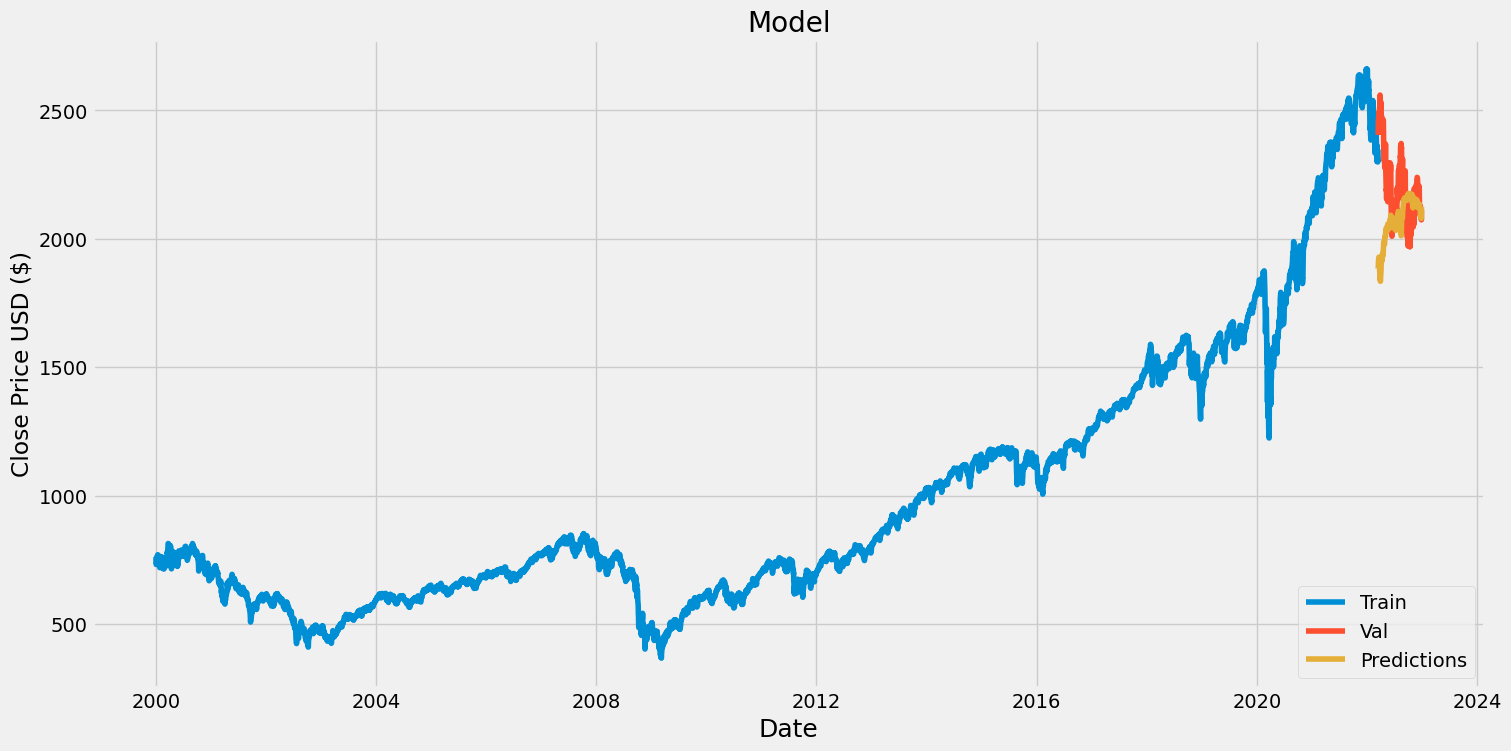

In [ ]:
#Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid.loc[:,'Predictions'] = predictions
#Visualising the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Download the Model Results

import pickle

variables = {
    'data': data,
    'training_data_len': training_data_len,
    'scaler': scaler,
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
    'predictions': predictions,
    'rmse': rmse,
    'mae': mae,
    'mape': mape,
    'amape': amape,
    'opt_learning_rate': opt_learning_rate,
    'opt_epochs': opt_epochs,
    'opt_batch_size': opt_batch_size,
    'opt_dropout': opt_dropout,
    'opt_activation_function': opt_activation_function,
    'opt_optimizer': opt_optimizer.__name__,
    'opt_neurons_1': opt_neurons_1,
    'opt_neurons_2': opt_neurons_2,
    'opt_neurons_3': opt_neurons_3,
    'opt_neurons_4': opt_neurons_4,
    'opt_l2_lambda': opt_l2_lambda

}

with open('gru_multi.pickle', 'wb') as f:
    pickle.dump(variables, f)
